In [5]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pickle 
import os

In [8]:
df = pd.read_csv("clientes_90min.csv")

In [9]:
df.columns

Index(['Unnamed: 0', 'ID_CLIENTE', 'LOCALIDAD', ' PROVINCIA ', 'COORDS', 'lat',
       'lon', 'tiempo_desde_sede_min'],
      dtype='object')

In [11]:
df.drop(columns=['Unnamed: 0', 'COORDS', 'tiempo_desde_sede_min'], inplace=True)

DataFrame original (primeras 5 filas):
   ID_CLIENTE     LOCALIDAD PROVINCIA        lat       lon
0           1          HARO  LA RIOJA  42.568106 -2.858153
1           3  STO. DOMINGO  LA RIOJA  42.433120 -2.950750
2           4        DURANA     ALAVA  42.887026 -2.639514
3           5          HARO  LA RIOJA  42.569054 -2.858238
4           6       VITORIA     ALAVA  42.837400 -2.670095

Columnas del DataFrame: ['ID_CLIENTE', 'LOCALIDAD', 'PROVINCIA', 'lat', 'lon']

Primeras 5 filas de datos escalados:
[[-0.01982868 -0.98184016]
 [-0.74488571 -1.32328481]
 [ 1.69320044 -0.17562745]
 [-0.01473572 -0.98215666]
 [ 1.42664281 -0.28839128]]


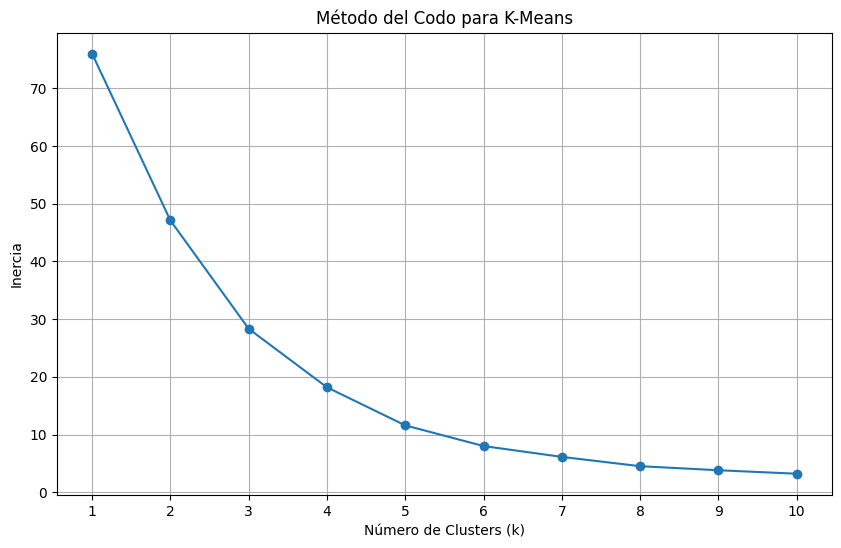


DataFrame con los clusters asignados (n_clusters=4):


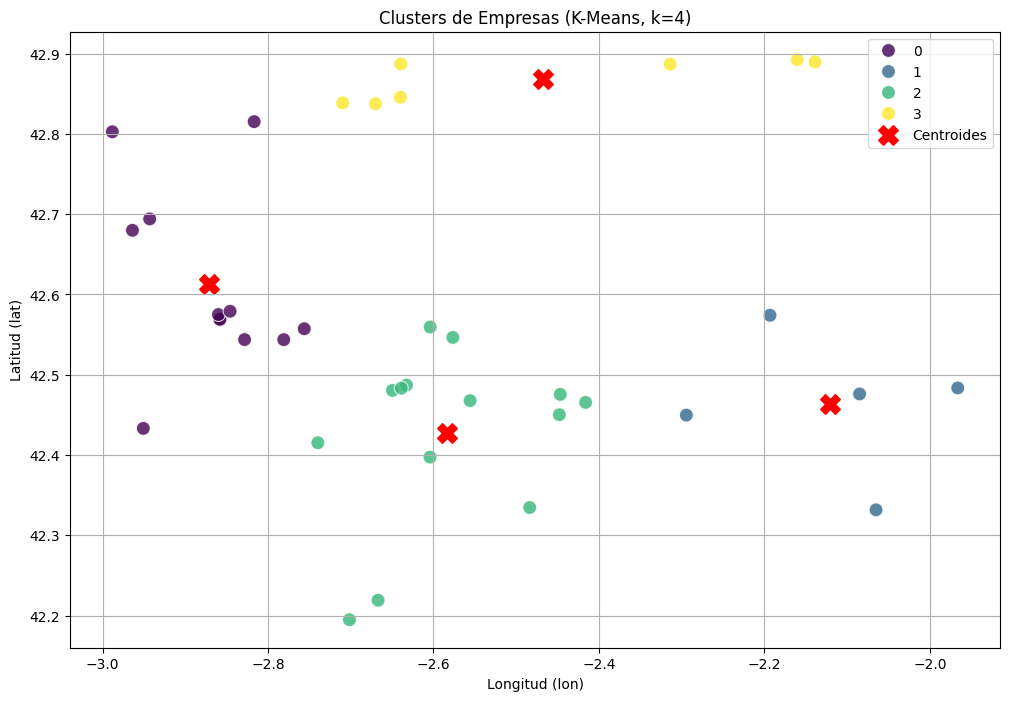


--- Resumen de Clusters para 4 rutas ---

Cluster 0:
  Número de empresas: 12
  Localidades: ['HARO', 'STO. DOMINGO', 'SAN VICENTE', 'NANCLARES', 'SALINAS', 'MIRANDA', 'BRIONES', 'OLLAURI']

Cluster 1:
  Número de empresas: 5
  Localidades: ['PRADEJÓN', 'AGONCILLO', 'SESMA', 'LERÍN', 'LOS ARCOS']

Cluster 2:
  Número de empresas: 14
  Localidades: ['LOGROÑO', 'SOTES', 'NALDA', 'EL RASILLO', 'NIEVA', 'CENICERO', 'LAGUARDIA', 'NAJERA', 'FUENMAYOR']

Cluster 3:
  Número de empresas: 7
  Localidades: ['DURANA', 'VITORIA', 'URDIAIN', 'ALSASUA', 'ARAIA']

DataFrame con clusters guardado en: empresas_con_clusters.csv
Scaler guardado en: modelos_ml\scaler_model.pkl
KMeans guardado en: modelos_ml\kmeans_model.pkl

Proceso completado.


In [13]:
df.columns = df.columns.str.strip()  # Eliminar espacios en nombres de columnas

print("DataFrame original (primeras 5 filas):")
print(df.head())
print("\nColumnas del DataFrame:", df.columns.tolist())

# --- 1. Selección de características para el clustering ---
features = ['lat', 'lon']
X = df[features]

# --- 2. Escalado de datos ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_for_clustering = X_scaled

print("\nPrimeras 5 filas de datos escalados:")
print(X_scaled[:5])

# --- 3. Método del Codo ---
inertia = []
k_range = range(1, min(len(X_for_clustering), 11))  # Máx. 10 clusters o número de puntos
for k in k_range:
    kmeans_model = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_model.fit(X_for_clustering)
    inertia.append(kmeans_model.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo para K-Means')
plt.xticks(k_range)
plt.grid(True)
plt.show()

# --- 4. Elegir el número de clusters ---
n_clusters = 4  # Ajusta este valor según el gráfico del codo

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X_for_clustering)

print(f"\nDataFrame con los clusters asignados (n_clusters={n_clusters}):")


# --- 5. Visualización ---
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df,
    x='lon',
    y='lat',
    hue='cluster',
    palette='viridis',
    s=100,
    alpha=0.8,
    legend='full'
)

centers = scaler.inverse_transform(kmeans.cluster_centers_)
plt.scatter(centers[:, 1], centers[:, 0], c='red', s=200, marker='X', label='Centroides')

plt.title(f'Clusters de Empresas (K-Means, k={n_clusters})')
plt.xlabel('Longitud (lon)')
plt.ylabel('Latitud (lat)')
plt.grid(True)
plt.legend()
plt.show()

# --- 6. Resumen por cluster ---
print(f"\n--- Resumen de Clusters para {n_clusters} rutas ---")
for i in range(n_clusters):
    cluster_df = df[df['cluster'] == i]
    print(f"\nCluster {i}:")
    print(f"  Número de empresas: {len(cluster_df)}")
    print(f"  Localidades: {cluster_df['LOCALIDAD'].unique().tolist()}")
 

# --- 7. Guardar resultados ---
df.to_csv('empresas_con_clusters.csv', index=False)
print(f"\nDataFrame con clusters guardado en: empresas_con_clusters.csv")

# --- 8. Guardar modelos ---
models_dir = 'modelos_ml'
os.makedirs(models_dir, exist_ok=True)

scaler_path = os.path.join(models_dir, 'scaler_model.pkl')
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)

kmeans_path = os.path.join(models_dir, 'kmeans_model.pkl')
with open(kmeans_path, 'wb') as f:
    pickle.dump(kmeans, f)

print(f"Scaler guardado en: {scaler_path}")
print(f"KMeans guardado en: {kmeans_path}")
print("\nProceso completado.")
